In [2]:
# import packages
%matplotlib nbagg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.widgets
import seaborn as sns

from tkinter import * 
import tkinter.messagebox 

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import RadioButtons
from sklearn import svm
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)


In [3]:
class Preprocessor:
    
    # initalise self with data needed to be preproccessed
    def __init__ (self, data):
        self.data = data

    def encode(self, kind: str, c_name):

        # update self.data with the appropriate encoder
        assert kind in ['onehot', 'label']
        self.kind = kind
          
        # do one hot encoder
        if self.kind == 'onehot':
            classes = set(self.data[c_name])
            for cls in classes:
                self.data[cls] = self.data[c_name].apply(lambda x: 1 if x == cls else 0)
            del self.data[c_name]
            return self.data
            
        # do label encoder
        else:
            classes = set(self.data[c_name])
            values = {list(classes)[i]: i for i in range(len(classes))}
            self.data[c_name] = self.data[c_name].apply(lambda x: values[x])

        return self.data
    
    def scaler(self, kind: str, c_name):
        
        # update self.data with the appropriate scaler
        
         # make sure kind is either minmax or standard
        assert kind in ['minmax', 'standard']

        # start with minmax
        if kind == 'minmax':
            min_value = min(self.data[c_name])
            max_value = max(self.data[c_name])
            diff = max_value - min_value
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - min_value) / diff)
            
            return self.data
        
        # then do standard scaler
        else:
            mean = self.data[c_name].mean()
            std = self.data[c_name].std()
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - mean) / std)
            
        return self.data

    # function to remove entire column of data
    def remove (self, c_name):
        del self.data[c_name]
        return self.data
     
    # function to replace unknown data with mean, median or dropping it
    def replace (self, c_name, kind):
        assert kind in ['mean', 'median','drop']
        
        if kind == 'mean':
            mean_value = self.data[c_name].mean()
            self.data[c_name] = self.data[c_name].fillna(mean_value)
            return self.data
        
        if kind == 'median':
            median_value = self.data[c_name].median()
            self.data[c_name] = self.data[c_name].fillna(median_value)
            return self.data
            
        else:
            self.data = self.data.dropna().reset_index(drop = True)
            return self.data

In [4]:
class preplotter:
    
    def __init__ (self, data):
        self.data = data
        
    # Function to plot linear 2D or 3D graph takes in column names and output graphs
        
    # func to plots scatter graphs 
    # for these functions column names are input, hence by setting the z name to 0 and checking it is not a string
    # we can seperate 3D plots from 2D plots
    
    # for all the functions below, they follow a similar manner
    # get fig ax objects
    # label axis
    # plot graph 
    
    def scatter(self, x_name, y_name, z_name = 0 ):
        
        # check if data has 3rd dimension
        if z_name == 0:
            
            # gen fig and ax for 2D
            fig, ax = plt.subplots()
            
            # label fig and ax
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            
            # plot data
            ax.scatter(self.data[x_name], self.data[y_name], alpha=0.5)
        
        # generate and for above but in 3D graph
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            
            # label fig and ax
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            ax.set_zlabel(z_name)
            
            # plot data
            ax.scatter(self.data[x_name], self.data[y_name], self.data[z_name])    
    
    # func to plot line graphs same as above
    
    def line(self, x_name, y_name, z_name = 0):
        if z_name == 0:
            fig, ax = plt.subplots()
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            
            ax.plot(self.data[x_name], self.data[y_name])
            
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            ax.set_zlabel(z_name)
            
            ax.plot(self.data[x_name], self.data[y_name], self.data[z_name])
            
    # plot multiple line plots with radio buttons
    
    def multiline (self, x_list , y_list, z_list = 0):
        
        #hard set colours to be used, don't expect more than 8 values to be plotted at once
        colours = ('blue', 'green', 'orange', 'red', 'yellow' , 'purple', 'black', 'pink')

        # check if input has 3 dimension
        if z_list == 0:

            # gen fig, ax adjusted for radio buttons
            fig, ax = plt.subplots()
            plt.subplots_adjust(left=0.45)

            # generate empty dictionary
            lines = {}
            
            # generate line dictionary using x_list as keys
            for i ,name in enumerate(x_list):

                if i == 0:
                    lines[name] = ax.plot( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.5)

                else:
                    lines[name] = ax.plot( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.025)

            # create radio box
            radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')

            # create radio buttons
            radio = RadioButtons( radio_ax, x_list)

            # callback function to run when buttons are pressed
            def callback(label: str):
                for name, line in lines.items():
                    if name == label:
                        line[0].set_alpha(0.5)
                    else:
                        line[0].set_alpha(0.025)
                plt.draw()
                return

            # connect function to radio object and show
            radio.on_clicked(callback)

            plt.show()

            return radio


        # if in 3D do simple colour plot
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            for i in range(len(x_list)):
                ax.plot( self.data[x_list[i]], self.data[y_list[i]], self.data[z_list[i]], label= x_list[i], alpha = 0.5)
                plt.legend()


    # plot multiple scatter plots do the same as above
    
    def multiscatter (self, x_list , y_list, z_list = 0):

        colours = ('blue', 'green', 'orange', 'red', 'yellow' , 'purple', 'black', 'pink')

        if z_list == 0:

            fig, ax = plt.subplots()
            plt.subplots_adjust(left=0.45)

            lines = {}

            for i ,name in enumerate(x_list):

                if i == 0:
                    lines[name] = ax.scatter( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.5)

                else:
                    lines[name] = ax.scatter( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.025)

            # create radio box
            radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')

            # create radio buttons
            radio = RadioButtons( radio_ax, x_list)

            # callback function to run when buttons are pressed
            def callback(label: str):
                for name, line in lines.items():
                    if name == label:
                        line.set_alpha(0.5)
                    else:
                        line.set_alpha(0.025)
                plt.draw()
                return

            # connect function to radio object and show
            radio.on_clicked(callback)

            plt.show()

            return radio


        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            for i in range(len(x_list)):
                ax.scatter( self.data[x_list[i]], self.data[y_list[i]], self.data[z_list[i]], label= x_list[i], alpha = 0.5)
                plt.legend()

                
    # this function plots a boolean data type's coordination with strokes
    def histogram (self, x_list):

        # initalise figure and bins
        fig, ax = plt.subplots()
        bins = [0 ,1]
        
        # filter data out based on if boolean is 1 or 0
        
        inter = data[data[x_list] == 1]
        # check amount of strokes for bool of 1
        strokes = len(inter[inter['stroke'] == 1])
        sstrokes = len(inter)
        # find % strokes
        pstrokes = (strokes/sstrokes)*100
        print(f' the percentage of strokes with 1 is {pstrokes}%.')
        
        # repear with bool of 0
        inter2 = data[data[x_list] == 0]
        nstrokes = len(inter2[inter2['stroke'] == 1])
        snstrokes = len(inter2)
        pnstrokes = (nstrokes/snstrokes)*100
        print(f' the percentage of strokes with 0 is {pnstrokes}%.')
        
        # plot these 2 percentage chances against each other and print difference
        score = [pnstrokes, pstrokes]
        ax.bar(bins,score)
        dv = pstrokes - pnstrokes
    
        print(f'the percentage difference is {dv}%.')
        
        return dv


In [5]:
class postplotter:
    
    #initalise self with regressor object and test data
    def __init__ (self, x_test, y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
        self.x_test = x_test
    # plots real values xy slope = 1 and predicted values variance from that

#     def preplot (self):

#         fig, ax = plt.subplots()
#         ax.plot(self.y_test, self.y_test, 'r-', label='Real')
#         ax.scatter(self.y_test, self.y_pred, label = 'prediction')
#         ax.set_xlabel('Test Data')
#         ax.set_ylabel('Predicted/Test Data')
#         ax.legend(frameon=False)
#         ax.set_title('Prediction graph')
        
    # plots confusion matrix and gives FR values
        
    def confmatrix (self):
    
#         fig, ax = plt.subplots()
        array = np.zeros((2, 2))

        for i, correct_value in enumerate(self.y_test):
            predicted_value = int(abs(np.round(self.y_pred[i])))
            array[predicted_value, correct_value] += 1

        # print dataframe represenation of array
        print(pd.DataFrame(array))

        # plot array as image
#         im = ax.imshow(array, origin='lower', cmap='hot_r')

#         # label axes
#         ax.set_xlabel('Real Type')
#         ax.set_ylabel('Predicted Type')

#         # add colorbar
#         plt.colorbar(im)
        
        #calculates F1, P and R values
        P = (array[1,1]/(array[1,1]+array[0,1]))*100
        R = (array[1,1]/(array[1,1]+array[1,0]))*100
        F1 = 2*P*R/(P+R)

        print(f'Precision is:\n\n{P:2f}%\n')
        print(f'recall is:\n\n{R:2f}%\n')
        print(f'F-score is:\n\n{F1:2f}%\n')

In [44]:
def load(fname: str, cv: str) -> tuple:
    # basic spliter for now
    """Loads 2 column data from a CSV file with 2 columns, x and y"""

    # read data
    data = pd.read_csv(fname)
    y_column = 'stroke'
    # get training data
    #n_rows = int(len(data) * training_ratio)

    X_columns = list(data.columns)
    X_columns.remove(y_column)
    X = data[X_columns].to_numpy()
    y = data[y_column].to_numpy()

    # splitting calling the scikit split method of each cross validator
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # return all
    return X, y, X_train, y_train, X_test, y_test

class Regressor:
    """Container for analysing different metrics for a single regression class"""
    def __init__(self, cls, fname: str, cv, cls_kwargs: dict = {}, cv_kwargs: dict = {} ):
        # construct regressor object
        self.regressor = cls(**cls_kwargs)
        self.cv = cv(**cv_kwargs)

        # use load function
        # where cv is a splitting class i.e kFold()
        self.X, self.y, self.X_train, self.y_train, self.X_test, self.y_test = load(fname, self.cv)

        # fit data
        self.regressor.fit(self.X_train, self.y_train)

        # get predicted data
        self.y_pred = np.round(self.regressor.predict(self.X_test))

    def metric(self, cls, **kwargs) -> float:
        """Takes a sklearn.metrics class and returns the score of the regressor object"""

        # use the metric class to get a score
        return cls(self.y_test, self.y_pred)
    
    def predict(self, newdata):
        y = self.regressor.predict(newdata)
        return y
    
    


In [61]:
data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
# initialise preporcessor class
preprocessor = Preprocessor(data.copy())

# known id is irrelavent to stroke chance
preprocessor.remove('id')

# there is enough data to justify dropping NaN values in bmi
preprocessor.replace('bmi','drop')

# there are only 2 people with other as a gender, as insensitive as this is, they can be dropped
preprocessor.encode('onehot','gender')
preprocessor.remove("Other")

# there are only 2 marriage options, no live in partners or polygamy smh
preprocessor.encode('label','ever_married')

# more than 2 work tpyes - > onehot
preprocessor.encode('onehot','work_type')

# there are only 2 residencital types and one is obviously better than the other
preprocessor.encode('label','Residence_type')

# there are 4 smoking statuses, and the labeling hierarchy makes no sense
preprocessor.encode('onehot','smoking_status')

# unknown smoking data can be dropped
preprocessor.remove('Unknown')

# all other data is between 1 and 0 as such to keep all data compareable, we should use minmax scaling as it also keeps
# values within 1 and 0
preprocessor.scaler('minmax','age')
preprocessor.scaler('minmax','avg_glucose_level')
preprocessor.scaler('minmax','bmi')
# preprocessor.data = preprocessor.data.sample(frac=1).reset_index(drop=True)

#output data to another csv file
preprocessor.data.to_csv('data/preprocessed-healthcare-dataset-stroke-data.csv',index=False)

hypertension


<ipython-input-4-2ceeeef6907a>:186: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


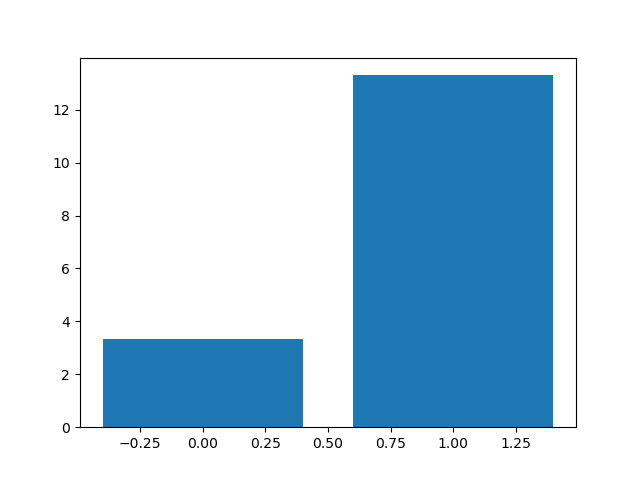

 the percentage of strokes with 1 is 13.303769401330376%.
 the percentage of strokes with 0 is 3.342305966801256%.
the percentage difference is 9.96146343452912%.
---------------------------------------------------------------------------------------------------------
heart_disease


<IPython.core.display.Javascript object>


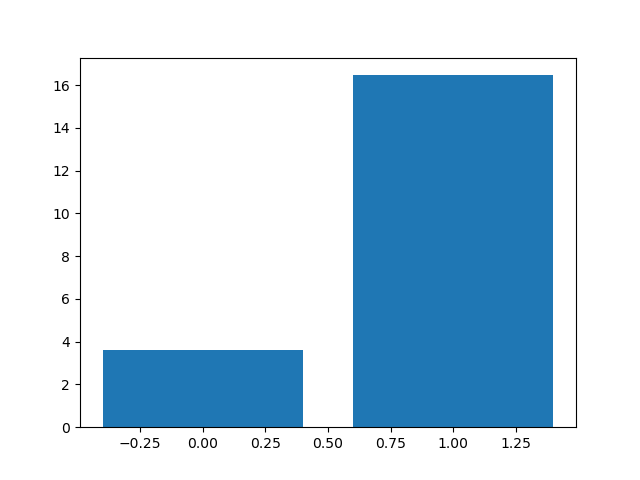

 the percentage of strokes with 1 is 16.46090534979424%.
 the percentage of strokes with 0 is 3.621945992284612%.
the percentage difference is 12.838959357509626%.
---------------------------------------------------------------------------------------------------------
ever_married


<IPython.core.display.Javascript object>


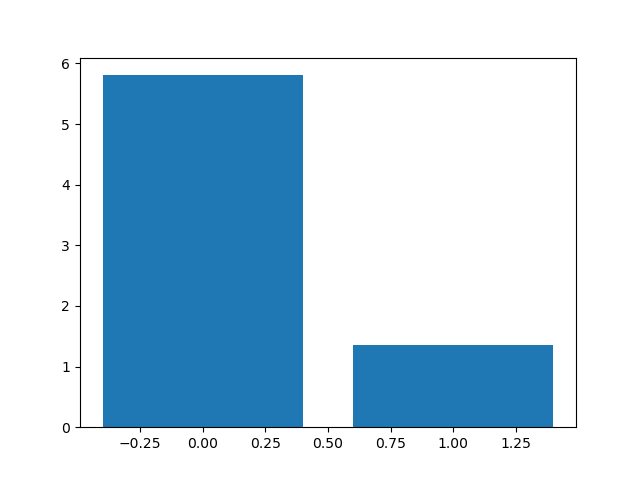

 the percentage of strokes with 1 is 1.3489736070381233%.
 the percentage of strokes with 0 is 5.805243445692884%.
the percentage difference is -4.456269838654761%.
---------------------------------------------------------------------------------------------------------
Residence_type


<IPython.core.display.Javascript object>


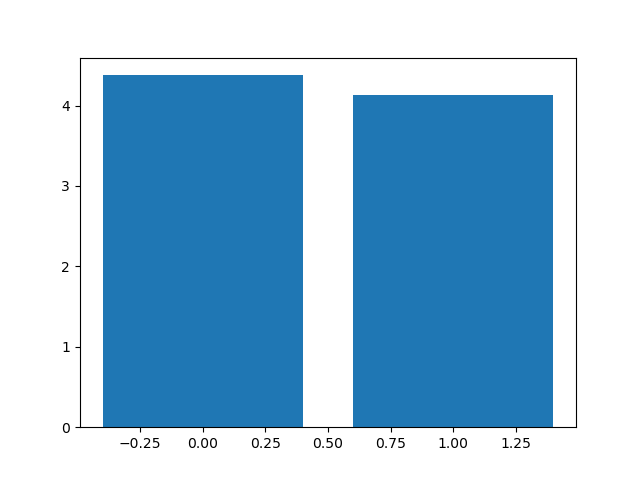

 the percentage of strokes with 1 is 4.13393964448119%.
 the percentage of strokes with 0 is 4.377510040160643%.
the percentage difference is -0.24357039567945282%.
---------------------------------------------------------------------------------------------------------
Male


<IPython.core.display.Javascript object>


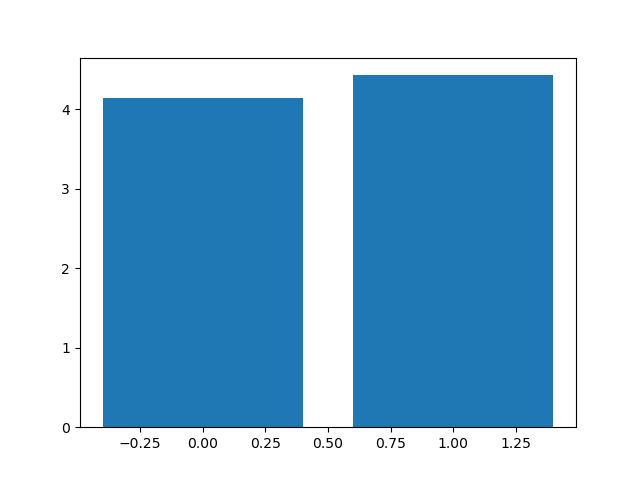

 the percentage of strokes with 1 is 4.4256588761810045%.
 the percentage of strokes with 0 is 4.140786749482402%.
the percentage difference is 0.28487212669860273%.
---------------------------------------------------------------------------------------------------------
Female


<IPython.core.display.Javascript object>


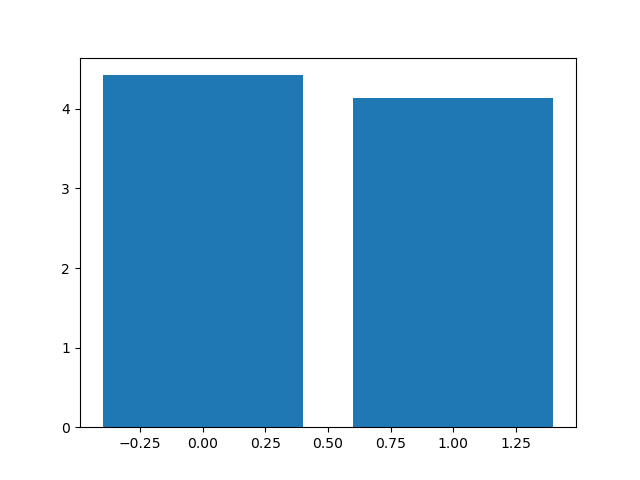

 the percentage of strokes with 1 is 4.142216085605799%.
 the percentage of strokes with 0 is 4.423459244532803%.
the percentage difference is -0.2812431589270039%.
---------------------------------------------------------------------------------------------------------
Private


<IPython.core.display.Javascript object>


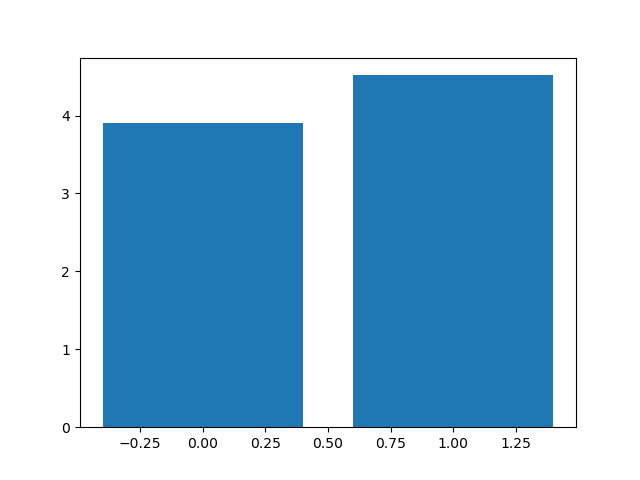

 the percentage of strokes with 1 is 4.517965136961935%.
 the percentage of strokes with 0 is 3.9084842707340326%.
the percentage difference is 0.6094808662279028%.
---------------------------------------------------------------------------------------------------------
Never_worked


<IPython.core.display.Javascript object>


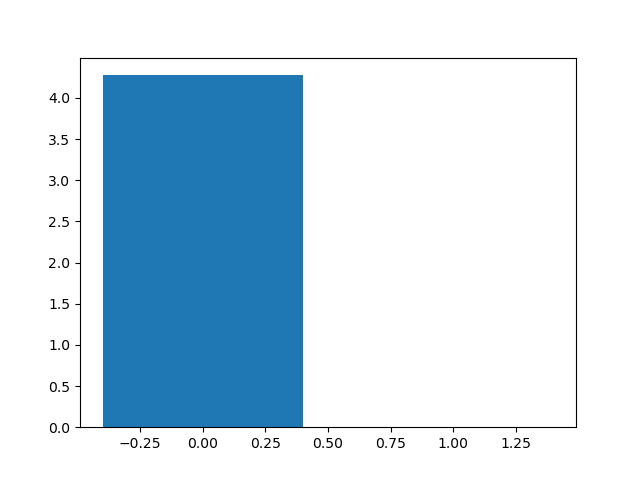

 the percentage of strokes with 1 is 0.0%.
 the percentage of strokes with 0 is 4.276652342950685%.
the percentage difference is -4.276652342950685%.
---------------------------------------------------------------------------------------------------------
children


<IPython.core.display.Javascript object>


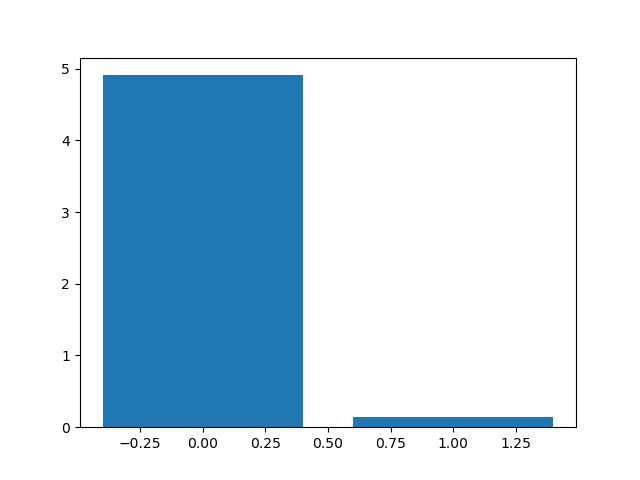

 the percentage of strokes with 1 is 0.14903129657228018%.
 the percentage of strokes with 0 is 4.9079754601226995%.
the percentage difference is -4.758944163550419%.
---------------------------------------------------------------------------------------------------------
Self-employed


<IPython.core.display.Javascript object>


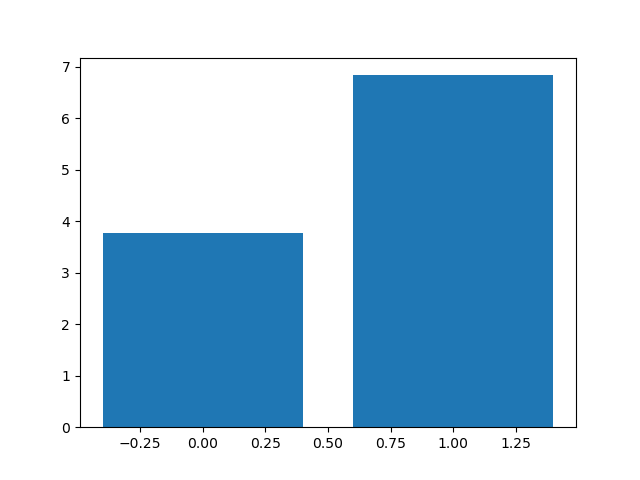

 the percentage of strokes with 1 is 6.838709677419355%.
 the percentage of strokes with 0 is 3.7735849056603774%.
the percentage difference is 3.0651247717589776%.
---------------------------------------------------------------------------------------------------------
Govt_job


<IPython.core.display.Javascript object>


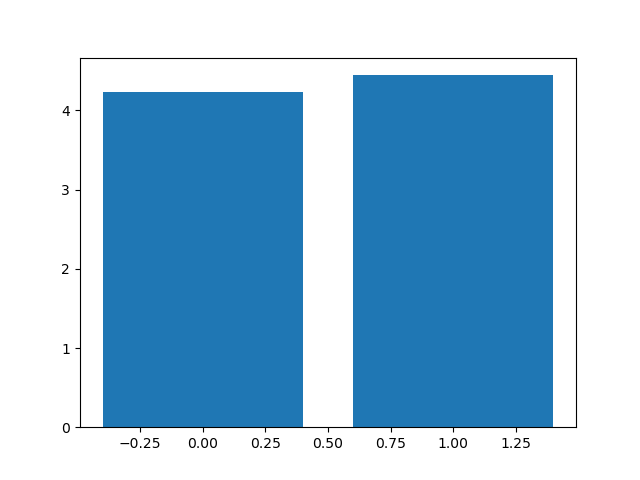

 the percentage of strokes with 1 is 4.444444444444445%.
 the percentage of strokes with 0 is 4.229960271091376%.
the percentage difference is 0.21448417335306846%.
---------------------------------------------------------------------------------------------------------
formerly smoked


<IPython.core.display.Javascript object>


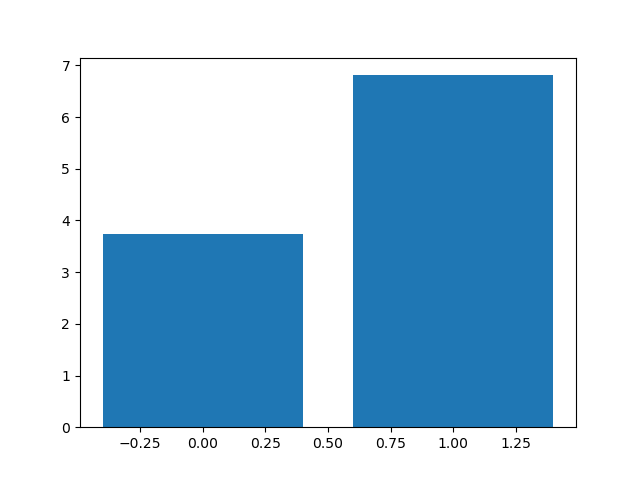

 the percentage of strokes with 1 is 6.810035842293908%.
 the percentage of strokes with 0 is 3.732809430255403%.
the percentage difference is 3.0772264120385047%.
---------------------------------------------------------------------------------------------------------
never smoked


<IPython.core.display.Javascript object>


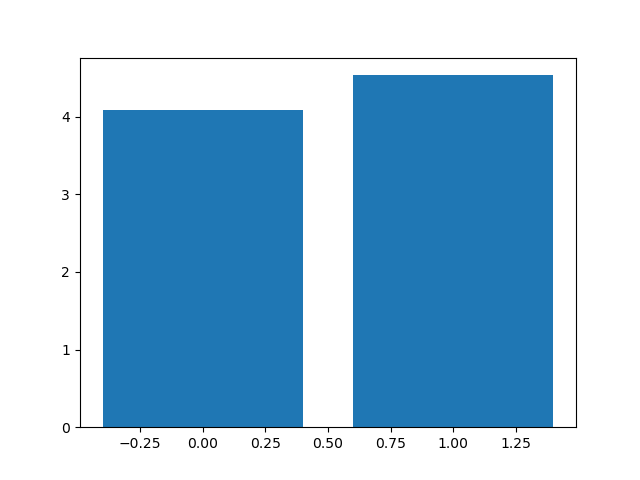

 the percentage of strokes with 1 is 4.535637149028078%.
 the percentage of strokes with 0 is 4.088976120379457%.
the percentage difference is 0.446661028648621%.
---------------------------------------------------------------------------------------------------------
smokes


<IPython.core.display.Javascript object>


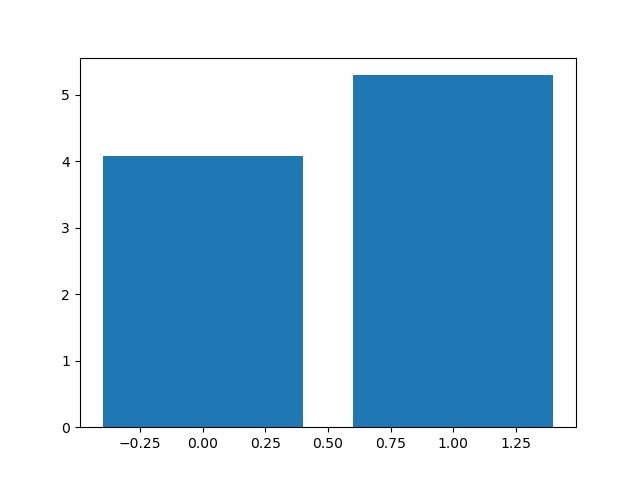

 the percentage of strokes with 1 is 5.291723202170964%.
 the percentage of strokes with 0 is 4.074784276126557%.
the percentage difference is 1.2169389260444063%.
---------------------------------------------------------------------------------------------------------
['Residence_type', 'Male', 'Female', 'Private', 'Govt_job']


In [94]:
data = pd.read_csv('data/preprocessed-healthcare-dataset-stroke-data.csv')

# get all keys from datasheet
bols = []
for key in data.columns:
    bols.append(key)

# remove non-bools manually, possible for small data set
bols.remove('age')
bols.remove('avg_glucose_level')
bols.remove('bmi')
bols.remove('stroke')
#bols.remove('never smoked')
#bols.remove('Unnamed: 0')

# manually set non-bool keys
nbols = ['age','avg_glucose_level','bmi']

# innitialse class
preplots = preplotter(data)
 
#remove_list = ['Unnamed: 0']
remove_list = []

# look over bool variables
for name in bols:
    print(name)
    # return difference in percentage stroke
    dv = preplots.histogram(name)
    print('---------------------------------------------------------------------------------------------------------')
    # remove data that has similar stroke percentage i.e. non-predictive of stroke chances
    if abs(dv) < 1.1 : #ARBITRARY VALUE SET
        remove_list.append(name)

remove_list.remove('never smoked')

print(remove_list)

# initalize preprocessor class agaon
data_p = Preprocessor(data.copy())
# remove 2nd wave of non-predictive data
for name in remove_list:
    data_p.remove(name)
    
# save to new file
data_p.data.to_csv('data/preprocessed2-healthcare-dataset-stroke-data.csv', index=False)


age


<IPython.core.display.Javascript object>


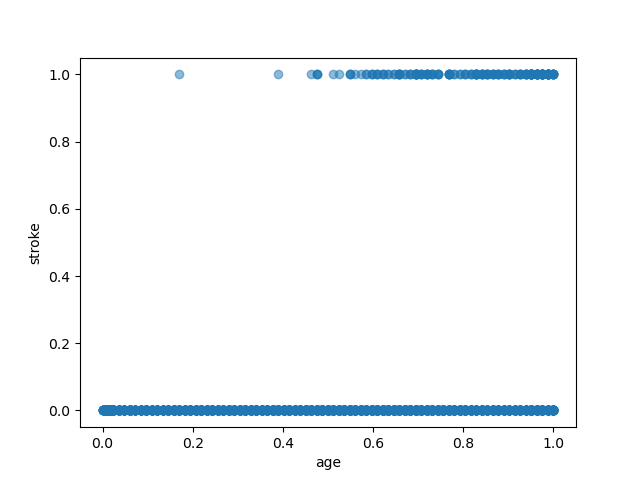

avg_glucose_level


<IPython.core.display.Javascript object>


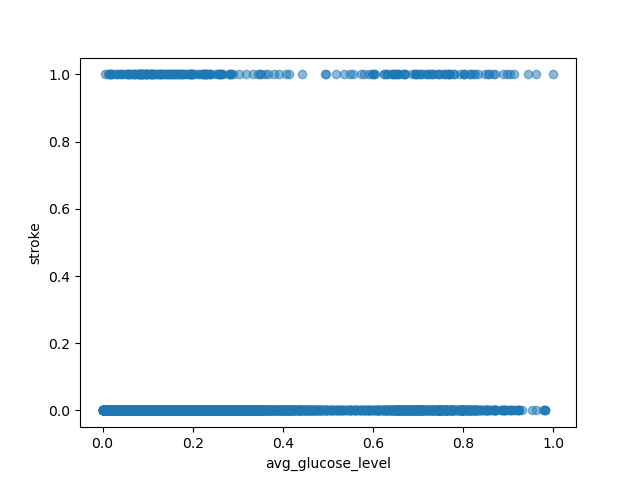

bmi


<IPython.core.display.Javascript object>


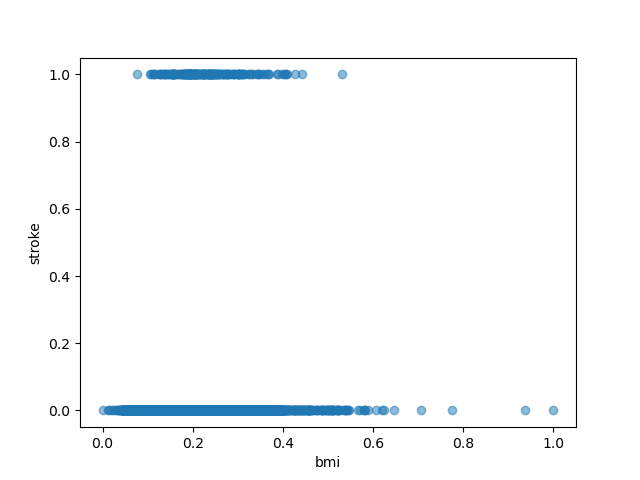

In [80]:
# print scatter graphs for each non-boolean function to check for corrolation
for name in nbols:
    print(name)
    preplots.scatter(name, 'stroke')

<IPython.core.display.Javascript object>


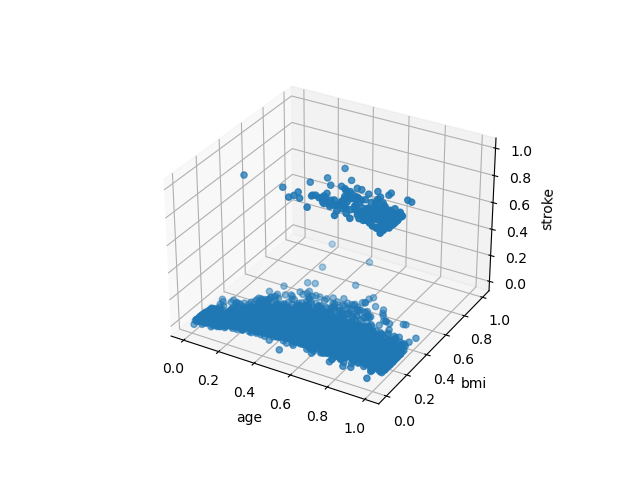

In [81]:
# plot 3D graphs to check for corrolation
preplots.scatter('age','bmi','stroke')

<IPython.core.display.Javascript object>


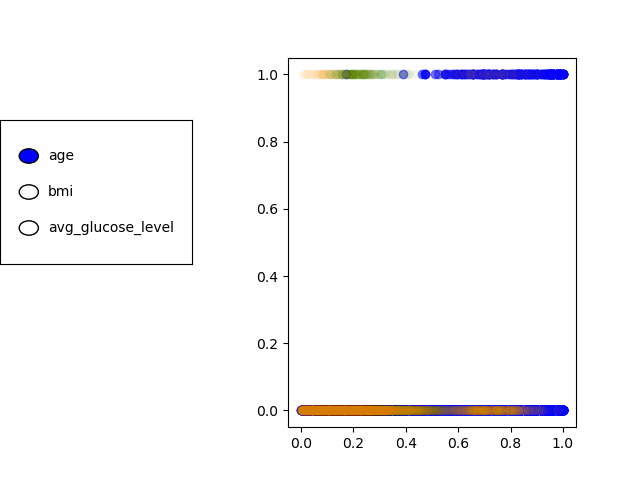

In [82]:
# using radio buttons we see the different data values
preplots.multiscatter(['age','bmi','avg_glucose_level'],['stroke','stroke','stroke'])

In [95]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

regressor:<class 'sklearn.linear_model._logistic.LogisticRegression'>, splitting:<class 'sklearn.model_selection._split.ShuffleSplit'>


<IPython.core.display.Javascript object>


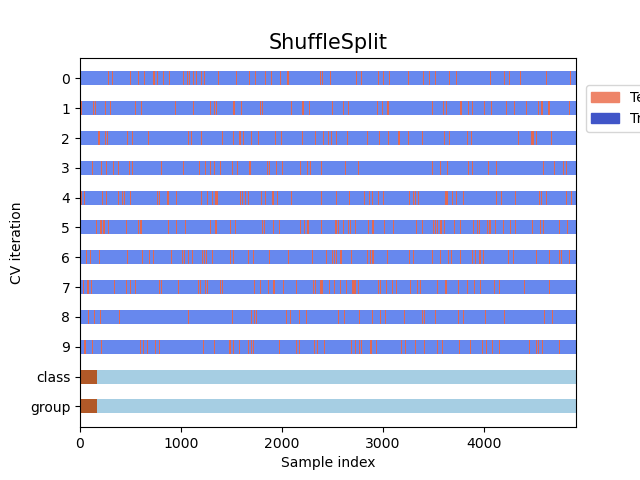

[1 1 1 ... 0 0 0]
       0     1
0  474.0  17.0
1    0.0   0.0
Precision is:

0.000000%

recall is:

nan%

F-score is:

nan%

regressor:<class 'sklearn.linear_model._logistic.LogisticRegression'>, splitting:<class 'sklearn.model_selection._split.StratifiedKFold'>


<ipython-input-5-86b4c874442b>:46: RuntimeWarning: invalid value encountered in double_scalars
  R = (array[1,1]/(array[1,1]+array[1,0]))*100
<ipython-input-96-d9aee8f0b65b>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


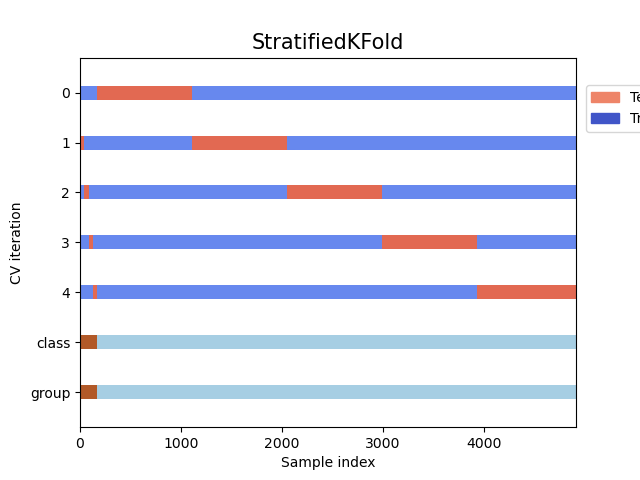

[1 1 1 ... 0 0 0]
       0     1
0  940.0  40.0
1    0.0   1.0
Precision is:

2.439024%

recall is:

100.000000%

F-score is:

4.761905%

regressor:<class 'sklearn.linear_model._logistic.LogisticRegression'>, splitting:<class 'sklearn.model_selection._split.KFold'>


<IPython.core.display.Javascript object>


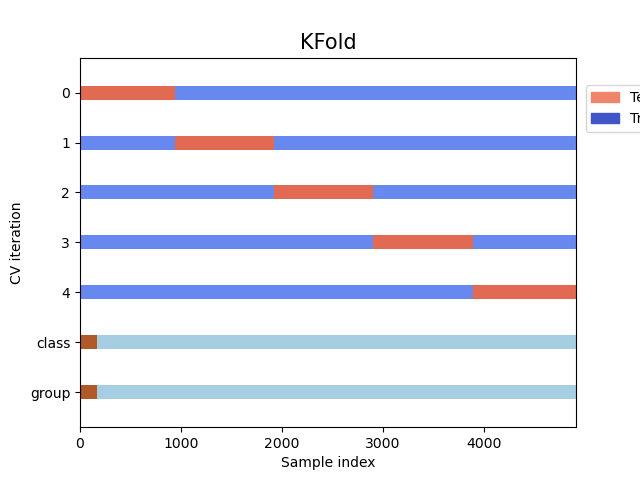

[1 1 1 ... 0 0 0]
       0    1
0  981.0  0.0
1    0.0  0.0
Precision is:

nan%

recall is:

nan%

F-score is:

nan%

regressor:<class 'sklearn.linear_model._logistic.LogisticRegression'>, splitting:<class 'sklearn.model_selection._split.RepeatedKFold'>


<ipython-input-5-86b4c874442b>:45: RuntimeWarning: invalid value encountered in double_scalars
  P = (array[1,1]/(array[1,1]+array[0,1]))*100
<ipython-input-5-86b4c874442b>:46: RuntimeWarning: invalid value encountered in double_scalars
  R = (array[1,1]/(array[1,1]+array[1,0]))*100


<IPython.core.display.Javascript object>


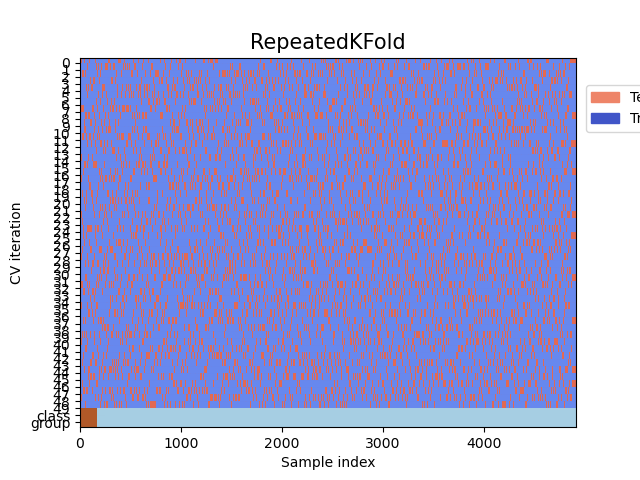

[1 1 1 ... 0 0 0]
       0     1
0  942.0  39.0
1    0.0   0.0
Precision is:

0.000000%

recall is:

nan%

F-score is:

nan%

regressor:<class 'sklearn.linear_model._logistic.LogisticRegression'>, splitting:<class 'sklearn.model_selection._split.StratifiedShuffleSplit'>


<ipython-input-5-86b4c874442b>:46: RuntimeWarning: invalid value encountered in double_scalars
  R = (array[1,1]/(array[1,1]+array[1,0]))*100


<IPython.core.display.Javascript object>


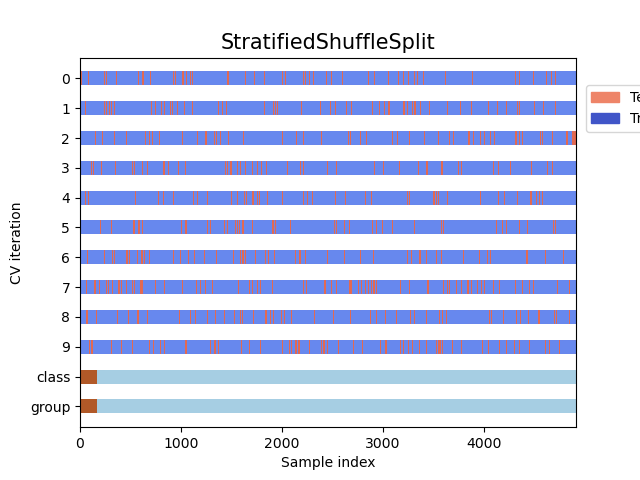

[1 1 1 ... 0 0 0]
       0     1
0  470.0  21.0
1    0.0   0.0
Precision is:

0.000000%

recall is:

nan%

F-score is:

nan%

regressor:<class 'sklearn.neighbors._classification.KNeighborsClassifier'>, splitting:<class 'sklearn.model_selection._split.ShuffleSplit'>


<ipython-input-5-86b4c874442b>:46: RuntimeWarning: invalid value encountered in double_scalars
  R = (array[1,1]/(array[1,1]+array[1,0]))*100


<IPython.core.display.Javascript object>


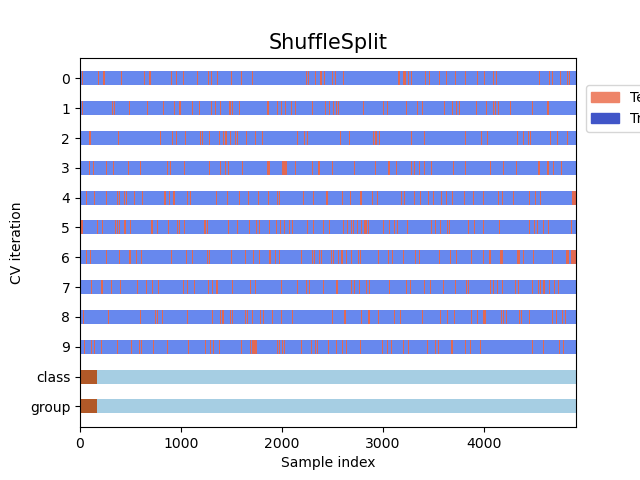

[1 1 1 ... 0 0 0]
       0     1
0  471.0  19.0
1    0.0   1.0
Precision is:

5.000000%

recall is:

100.000000%

F-score is:

9.523810%

regressor:<class 'sklearn.neighbors._classification.KNeighborsClassifier'>, splitting:<class 'sklearn.model_selection._split.StratifiedKFold'>


<IPython.core.display.Javascript object>


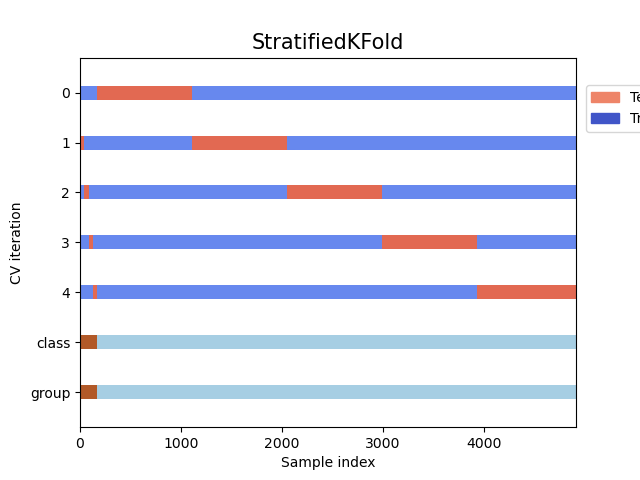

[1 1 1 ... 0 0 0]
       0     1
0  936.0  41.0
1    4.0   0.0
Precision is:

0.000000%

recall is:

0.000000%

F-score is:

nan%

regressor:<class 'sklearn.neighbors._classification.KNeighborsClassifier'>, splitting:<class 'sklearn.model_selection._split.KFold'>


<ipython-input-5-86b4c874442b>:47: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*P*R/(P+R)


<IPython.core.display.Javascript object>


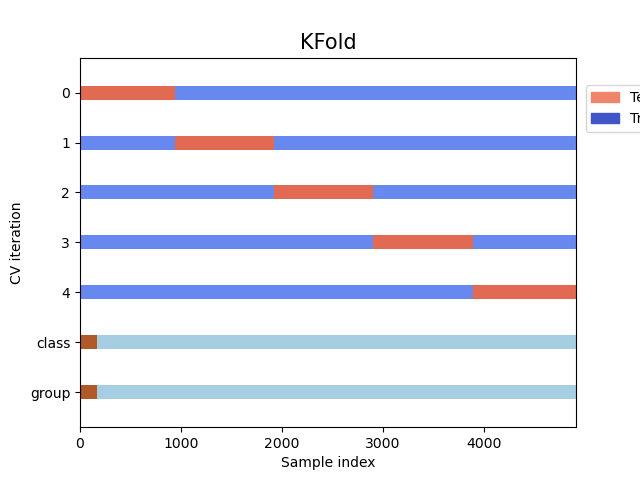

[1 1 1 ... 0 0 0]
       0    1
0  977.0  0.0
1    4.0  0.0
Precision is:

nan%

recall is:

0.000000%

F-score is:

nan%

regressor:<class 'sklearn.neighbors._classification.KNeighborsClassifier'>, splitting:<class 'sklearn.model_selection._split.RepeatedKFold'>


<ipython-input-5-86b4c874442b>:45: RuntimeWarning: invalid value encountered in double_scalars
  P = (array[1,1]/(array[1,1]+array[0,1]))*100


<IPython.core.display.Javascript object>


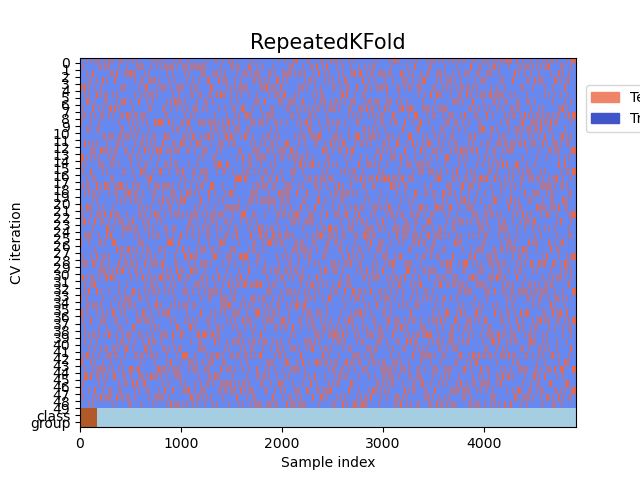

[1 1 1 ... 0 0 0]
       0     1
0  942.0  38.0
1    0.0   1.0
Precision is:

2.564103%

recall is:

100.000000%

F-score is:

5.000000%

regressor:<class 'sklearn.neighbors._classification.KNeighborsClassifier'>, splitting:<class 'sklearn.model_selection._split.StratifiedShuffleSplit'>


<IPython.core.display.Javascript object>


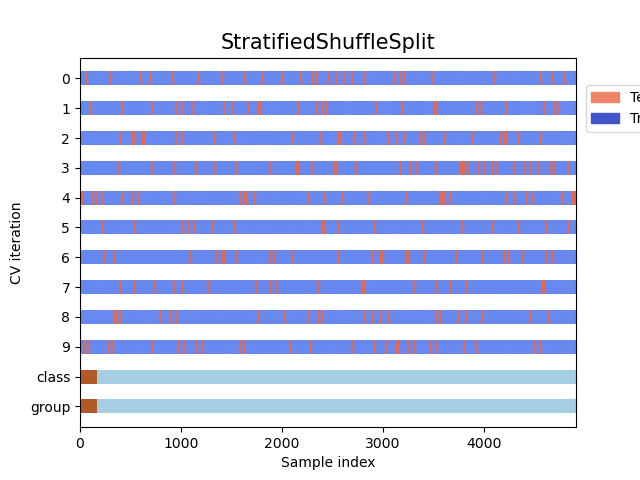

[1 1 1 ... 0 0 0]
       0     1
0  466.0  20.0
1    4.0   1.0
Precision is:

4.761905%

recall is:

20.000000%

F-score is:

7.692308%

regressor:<class 'sklearn.ensemble._forest.RandomForestRegressor'>, splitting:<class 'sklearn.model_selection._split.ShuffleSplit'>


<IPython.core.display.Javascript object>


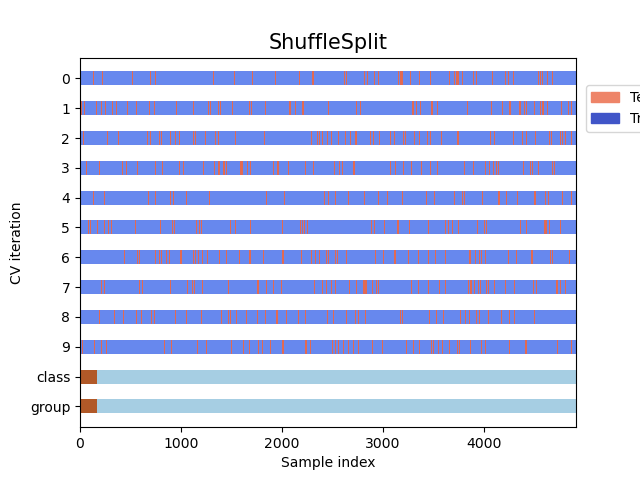

[1 1 1 ... 0 0 0]
       0     1
0  467.0  22.0
1    2.0   0.0
Precision is:

0.000000%

recall is:

0.000000%

F-score is:

nan%

regressor:<class 'sklearn.ensemble._forest.RandomForestRegressor'>, splitting:<class 'sklearn.model_selection._split.StratifiedKFold'>


<ipython-input-5-86b4c874442b>:47: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*P*R/(P+R)


<IPython.core.display.Javascript object>


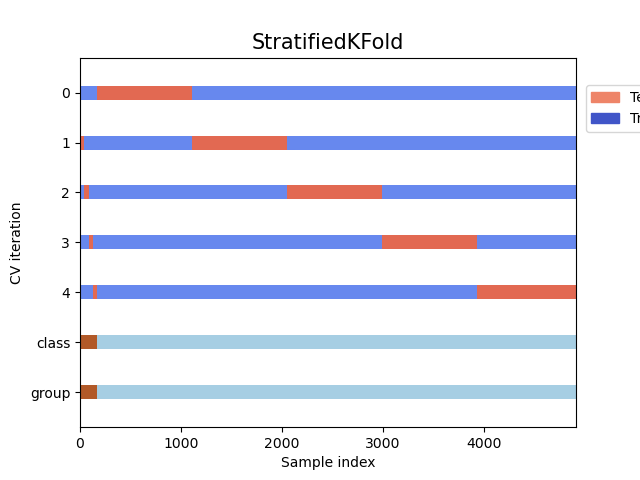

[1 1 1 ... 0 0 0]
       0     1
0  936.0  39.0
1    4.0   2.0
Precision is:

4.878049%

recall is:

33.333333%

F-score is:

8.510638%

regressor:<class 'sklearn.ensemble._forest.RandomForestRegressor'>, splitting:<class 'sklearn.model_selection._split.KFold'>


<IPython.core.display.Javascript object>


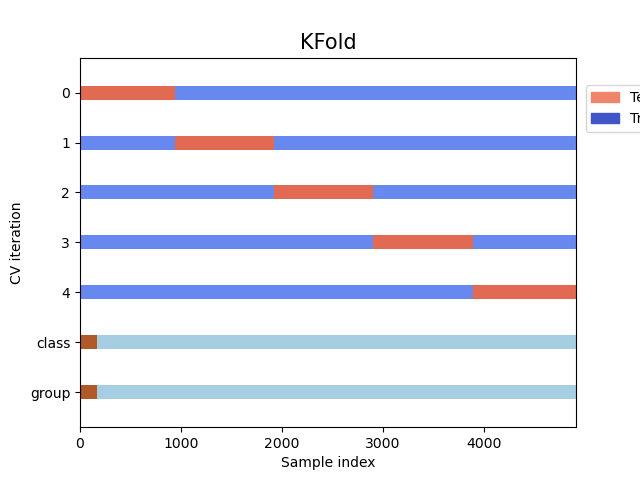

[1 1 1 ... 0 0 0]
       0    1
0  972.0  0.0
1    9.0  0.0
Precision is:

nan%

recall is:

0.000000%

F-score is:

nan%

regressor:<class 'sklearn.ensemble._forest.RandomForestRegressor'>, splitting:<class 'sklearn.model_selection._split.RepeatedKFold'>


<ipython-input-5-86b4c874442b>:45: RuntimeWarning: invalid value encountered in double_scalars
  P = (array[1,1]/(array[1,1]+array[0,1]))*100


<IPython.core.display.Javascript object>


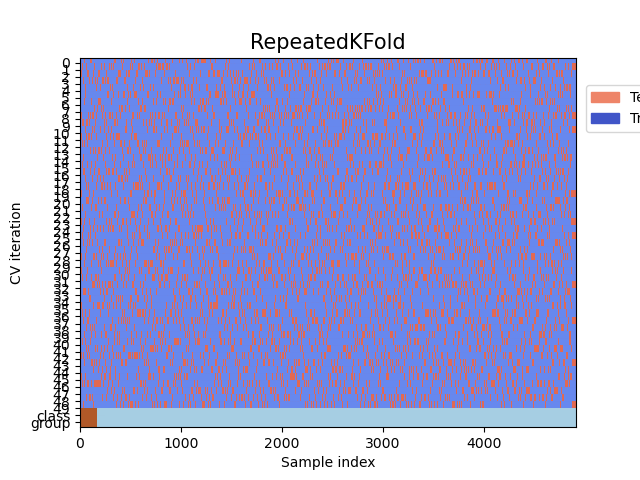

[1 1 1 ... 0 0 0]
       0     1
0  942.0  33.0
1    6.0   0.0
Precision is:

0.000000%

recall is:

0.000000%

F-score is:

nan%

regressor:<class 'sklearn.ensemble._forest.RandomForestRegressor'>, splitting:<class 'sklearn.model_selection._split.StratifiedShuffleSplit'>


<ipython-input-5-86b4c874442b>:47: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*P*R/(P+R)


<IPython.core.display.Javascript object>


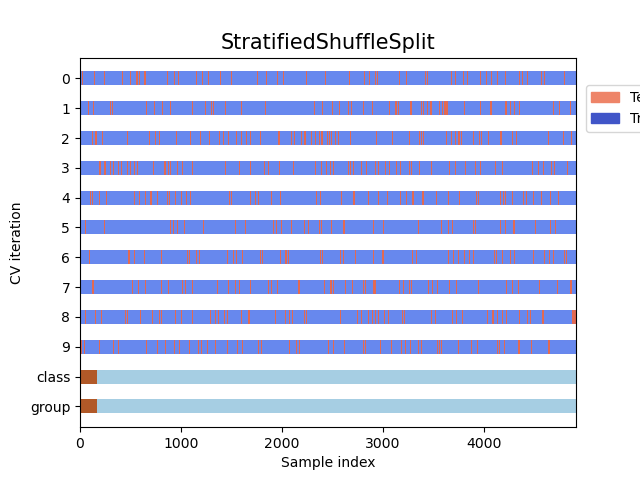

[1 1 1 ... 0 0 0]
       0     1
0  466.0  21.0
1    4.0   0.0
Precision is:

0.000000%

recall is:

0.000000%

F-score is:

nan%



<ipython-input-5-86b4c874442b>:47: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*P*R/(P+R)


In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib.patches import Patch
#Running different regressors with different splitting techniques and returns the confusion matrix in order
#to determine which ones to use for the data 
reg_list = [LogisticRegression, KNeighborsClassifier, RandomForestRegressor]
cv_list = [ShuffleSplit, StratifiedKFold, KFold, RepeatedKFold, StratifiedShuffleSplit]
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
#DEFINE FNAME
fname = 'data/preprocessed2-healthcare-dataset-stroke-data.csv'
groups_ = data['stroke'].to_numpy()
for regressor in reg_list: 
    for cv in cv_list:
        print(f'regressor:{regressor}, splitting:{cv}')
        rg = Regressor(regressor, fname, cv)
        a = postplotter(rg.X_test, rg.y_test, rg.y_pred)
        plotter = pd.DataFrame(rg.X_test)
        fig, ax = plt.subplots()
        print(rg.y)
        plot_cv_indices(rg.cv, rg.X, rg.y, rg.y, ax, rg.cv.get_n_splits() )
        ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))

        plotter['y_test'] = rg.y_test
        plotter['y_pred'] = rg.y_pred
#         print(plotter)
        a.confmatrix()
#         print(rg.y_test)
#         print(rg.y_pred)


In [85]:
#trying the RandomForestRegressor with different hyper parameters 
#parameters = np.

In [86]:
#trying the KNN classifier with different hyper parameters 

In [87]:
#rg = Regressor(regressor, fname, cv)
#plot_cv_indices()

In [88]:
rg = Regressor(LogisticRegression, fname, StratifiedKFold)
#np.array([])
array = np.array([4909, 0.2, 0, 0, 0, 0.01, 0.1,  0, 0, 0, 0])

predarray = array.reshape(1, -1)

print(type(rg.predict(predarray)))

rg.predict(predarray)()
#a = postplotter(rg.X_test, rg.y_test, rg.y_pred)
#plotter = pd.DataFrame(rg.X_test)
#a.confmatrix()
#fig, ax = plt.subplots()
      

<class 'method'>


TypeError: predict() missing 1 required positional argument: 'X'